## Description
Supervised classification is arguably the most important classical machine learning techniques in remote sensing. 
Applications range from generating Land Use/Land Cover maps to change detection. 
In this session, you will learn how to improve the results of classification technique to increase accuracy assessment.

## Aims of the practical session
* Load images for the region of interest
* Collect training samples
* Split smaples into training/validation data
* Correspond training data with the data
* Use classifier
* Calculate spectral indices
* Improve classifcaiton results
* Accuracy assessement 
* Calculating area by class

## Getting started

### Load packages

Import GEE packages that are needed for the analysis.

In [1]:
import ee
import geemap
# ee.Authenticate()

### Connect to Google Earth Engine (GEE)

Connect to the GEE to have access computing tools and GEE datasets.
You may be required to input your Google account for authorization.

In [2]:
Map = geemap.Map()
# Map.add_basemap('HYBRID')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Adding Region of Interest (ROI)

Create ROI that we want to work on it and then add and display it on the GEE map.
We can create ROI through manually drawing option in GEE or import the downloaded shapefile from your computer path. 

In [3]:
#Map.user_rois.getInfo()

In [4]:
geometry = ee.Geometry.Polygon([[
    [149.08169361455955, -35.32478551096885],
    [149.1481265674404, -35.325065623240356],
    [149.14829822881737, -35.27911424131675],
    [149.08289524419823, -35.27855369756653]
]])

Map.addLayer(geometry, {}, 'Canberra ROI')
Map.centerObject(geometry);

### Training data
Training data (or a training dataset) is the initial data used to train machine learning models. Import your pre-selected training dataset from your system.

In [5]:
#### load training data
trainingS_path = 'C:/Users/Abolfazl/Desktop/code/Google Earth Engine/training_data.shp'
training_data = geemap.shp_to_ee(trainingS_path)
Map.addLayer(training_data, {}, 'training_data')
Map.centerObject(training_data)

C:\Users\Abolfazl\Anaconda3\envs\gee\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Image collection
An ImageCollection is a stack or sequence of images. An ImageCollection can be loaded by pasting an Earth Engine asset ID into the ImageCollection constructor. You can find ImageCollection IDs in the <a href="https://developers.google.com/earth-engine/datasets">data catalog</a>. 

We will:
* Load Landsat-8 images for the anlysis
* Filter a collection by date range
* Stack images
* Clip based on the geometry
* Display it on Geemap

In [6]:
landsat = (
    ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
    .filterBounds(geometry)
    .filterDate('2020-09-01','2020-09-30')
#     .filter(ee.Filter.lessThan('CLOUD_COVER',10))
    .median()
    .clip(geometry)
)

vis_params = {'min': 0, 'max': 3000, 'bands': ['B5', 'B4', 'B3']}

# Map.centerObject(point, 8)
Map.addLayer(landsat, vis_params, "Landsat-8")
Map

Map(bottom=317228.0, center=[-35.30291509134112, 149.11238402028857], controls=(WidgetControl(options=['positi…

In [7]:
# # select bands wanted to use in the classifcation
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']

### Split the samples into training/test sets
The goal is to split up the region of interest into training data and validation data (with a randomization). The training set is used to train the model and test set is used to validate it.

In [8]:
# This property of the table stores the land cover labels.
label = 'landcover'
# # Add a random column and split the GCPs into training and validation set
gcp = training_data.randomColumn()

# # This being a simpler classification, we take 30% points
# # for validation. Normal recommended ratio is
# # 70% training, 30% validation
trainingGcp = gcp.filter(ee.Filter.lt('random', 0.7))
validationGcp = gcp.filter(ee.Filter.gte('random', 0.7))
#Map.addLayer(trainingGcp)

### Calculate and add more inputs to the model
The goal is to calculate some common spectral indices and then use those as inputs in the classification methods to improve the classification results.
We will:
* Calculate different spectral indices
* Composite that information with the image's bands
* Use all information as an input for the ML methods

In [9]:
# # # calculate spectral indices
composite = landsat.select(bands)

def addIndices(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename(['ndvi'])
    return image.addBands(ndvi)

composite = addIndices(composite)

### Sample imagery at training points to create training datasets
Now that we have created the points and labels, we need to sample the imagery using image.sampleRegions(). This command will extract the reflectance in the designated bands for each of the points you have created. 

We will then:
* Select the bands for training
* Sample the input imagery to get a FeatureCollection of training data

In [10]:
# # Overlay the point on the image to get training data.

training = composite.sampleRegions(
    **{
  'collection': trainingGcp,
  'properties': [label],
  'scale': 30}
)
print(training.size().getInfo())

241


### Classifcation method
The <a href="https://developers.google.com/earth-engine/guides/classification">Classifier</a> package in handles supervised classification by ML algorithms running in Earth Engine. Thus, in this part we will:
* Instantiate a supervised classifier
* Set its parameters if necessary
* Train the classifier using the training data
* Classify an image or feature collection
* Display the classified map

In [11]:
# # classifier
classifier = ee.Classifier.libsvm().train(**{
  'features' : training,
  'classProperty' : 'landcover',
  'inputProperties' : composite.bandNames()
})

classified = composite.classify(classifier)

# # Display the clusters with random colors.
Map.addLayer(classified.randomVisualizer(), {}, 'classified')
Map

Map(bottom=1268932.0, center=[-35.302797817405796, 149.11262512207034], controls=(WidgetControl(options=['posi…

### Accuracy assessment
Use validation samples to assess the accuracy of a classifier, use a Confusion Matrix (<a href="http://www.sciencedirect.com/science/article/pii/S0034425797000837">Stehman 1997</a>) to calculate overall accuracy (OA) and Kappa coefficient. 

In [12]:
# # # Accuracy Assessment
test = classified.sampleRegions(
    **{
  'collection': validationGcp,
  'properties': [label],
  'scale': 30}
)
print(test.size().getInfo())

108


In [13]:
# # # confusion matrix
test_accuracy = test.errorMatrix('landcover', 'classification')
test_accuracy.getInfo()

[[21, 1, 10, 0], [2, 22, 0, 0], [5, 2, 35, 0], [0, 0, 0, 10]]

In [14]:
# # accuracy
test_accuracy.accuracy().getInfo()

0.8148148148148148

In [15]:
# # kappa
test_accuracy.kappa().getInfo()

0.7358767424798237

### Calculating area by class
This code shows how to calculate area covered by each class in a classified image. It also shows how to create a chart showing the area for each class.

In [16]:
######/ Calculating Area by Class

# Create a 2 band image with the area image and the classified image
# Divide the area image by 1e6 so area results are in Sq Km
areaImage = ee.Image.pixelArea().divide(1e6).addBands(classified)

In [17]:
# Calculate Area by Class
# Using a Grouped Reducer
areas = areaImage.reduceRegion(**{
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'classification',
    }),
    'geometry': geometry,
    'scale': 30,
    'maxPixels': 1e9
    })

In [18]:
classAreas = ee.List(areas.get('groups'))
print(classAreas.getInfo())

[{'classification': 0, 'sum': 9.540741825102952}, {'classification': 1, 'sum': 4.290115072895818}, {'classification': 2, 'sum': 11.535381921957626}, {'classification': 3, 'sum': 5.294377632871187}]


### Create a chart

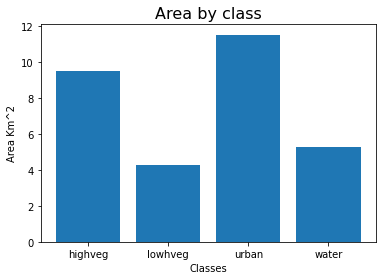

In [19]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots()

classSum = [9.540741825102952, 4.290115072895818, 11.535381921957626, 5.294377632871187]
classLabels = ['highveg', 'lowhveg', 'urban', 'water']

plt.bar(classLabels, classSum)
plt.xlabel('Classes')
plt.ylabel('Area Km^2')
ax.set_title('Area by class', fontsize=16);

<span style='background:yellow'> <span style="font-size:16.0pt"> Exercise  </span>

### Exercise 1 - Add other piece of information 
Try to calculate and add other information, such as more learned spectral indices to the model to see how the results will be changed. A list of spectral indices that can be used as expressions for computing spectral indices in GEE.

#### Then try to answer the following questions:
* what is the difference between various metrics?
* What kind of indices information did you calculate?
* try different indices for capturing information for different features to see how that index works and how the results change?
* Is the accuracy of the model changed by adding more information or not and why?
* recalculate area by class and check  the changes?

## References
This is where the references go. For exmaple:

* Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305

* "Earth Observation: Data, Processing and Applications" book. Available through Wattle, or http://www.crcsi.com.au/earth-observation-series.

## Additional information

**License:** The code in this notebook was initially created by the team at [Digital Earth Australia](https://github.com/GeoscienceAustralia/dea-notebooks), and has been modified by Abolfazl Abdollahi. The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle site.

**Last modified:** June 2022

### Exercise answers

<a name="ex1answer">Answer to Exercise 1</a>

In [16]:
# def addIndices(image):
#   ndvi = image.normalizedDifference(['B5', 'B4']).rename(['ndvi'])
#   ndbi = image.normalizedDifference(['B6', 'B5']).rename(['ndbi'])
#   ndwi = image.normalizedDifference(['B3', 'B5']).rename(['ndwi'])
#   gndvi = image.normalizedDifference(['B5', 'B3']).rename(['gndvi'])
#   return image.addBands(ndvi).addBands(ndbi).addBands(ndwi).addBands(gndvi)

# composite = addIndices(composite)